In [213]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import splitfolders

In [214]:
# Constants
DATASET_DIR = 'dataset'
CATEGORIES = ["fossil", "leaves"]
IMG_SIZE = 224  # Resize all images to 200x200

In [215]:
splitfolders.ratio(DATASET_DIR ,seed=1337, output="trash-Splitted", ratio=(0.7, 0.15, 0.15))

In [216]:
image_size = (224, 224)
batch_size = 64
train_path = 'trash-Splitted/train/'
val_path = 'trash-Splitted/val/'
test_path = 'trash-Splitted/test/'


train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

y_train = train_generator.classes
y_val = val_generator.classes
y_test = test_generator.classes



Found 375 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [217]:
# Create the model

from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [218]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(256, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [219]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [220]:
import numpy as np
from sklearn.utils import class_weight
# # Assuming you have a list of labels for your dataset, e.g., train_labels
train_labels = y_train  # Replace with the list of your training labels
# # Calculate class weights based on the frequency of each class
class_weights = class_weight.compute_class_weight(
class_weight='balanced',
classes=np.unique(train_labels),
y=train_labels
)
# # Convert class weights to a dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.7978723404255319, 1: 1.3392857142857142}


In [222]:
# Train the model with data augmentation
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

c:\Users\LapTop\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.5869 - loss: 0.7090 - val_accuracy: 0.8000 - val_loss: 0.5933
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.7274 - loss: 0.5666 - val_accuracy: 0.8750 - val_loss: 0.4889
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.8941 - loss: 0.4727 - val_accuracy: 0.6750 - val_loss: 0.4576
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.8323 - loss: 0.4155 - val_accuracy: 0.8875 - val_loss: 0.3872
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.9224 - loss: 0.3616 - val_accuracy: 0.9125 - val_loss: 0.3539
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.9046 - loss: 0.3178 - val_accuracy: 0.8875 - val_loss: 0.3511
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.9426 - loss: 0.2838 - val_accuracy: 0.8875 - val_loss: 0.3026
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.9499 - loss: 0.2515 - val_accuracy: 0.9000 - val_loss: 0.2825
Epoch 9/

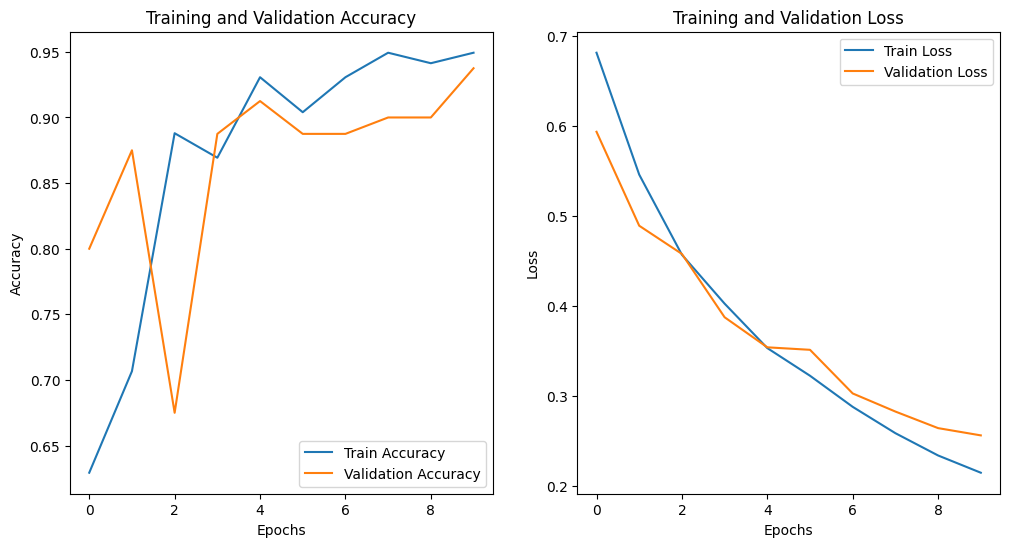

In [223]:
# Plotting training accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Confusion Matrix:
 [[1. 0.]
 [1. 0.]]


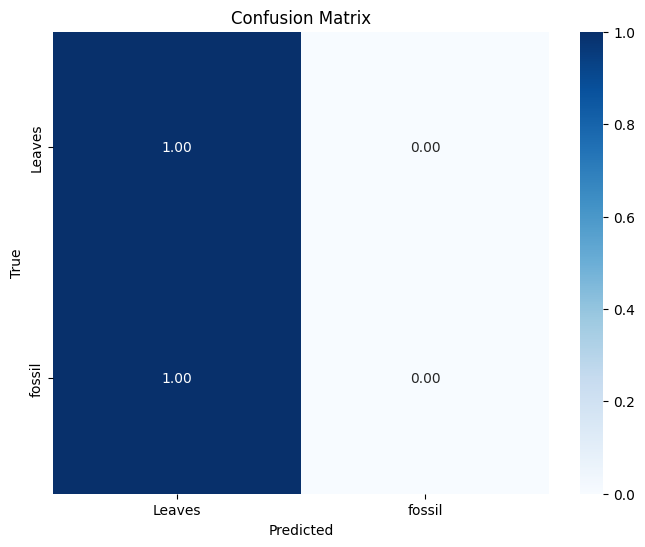

In [225]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns  # for visualization (optional)

# Evaluate the model on test data
predictions = model.predict(test_generator)
y_pred_probs = predictions  # Assuming predictions contain probabilities

# If y_pred_probs contains class labels, convert to one-hot encoding
if len(y_pred_probs.shape) == 1:
  y_pred = to_categorical(y_pred_probs, num_classes=2)  # Assuming binary classification
else:
  y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Ensure y_true matches the order of test images
y_true = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')  # Normalize for percentages

# Print confusion matrix
print("Confusion Matrix:\n", cm)

# Visualize confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [227]:
# Evaluate the model on test data
predictions = model.predict(test_generator)
y_pred_probs = predictions  # Assuming predictions contain probabilities

# If y_pred_probs contains class labels, convert to one-hot encoding
if len(y_pred_probs.shape) == 1:
    y_pred = to_categorical(y_pred_probs, num_classes=2)  # Assuming binary classification
else:
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels (if needed)

# Ensure y_true matches the order of test images
y_true = test_generator.classes

# Classification Report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
Classification Report:
              precision    recall  f1-score   support

      fossil       0.63      1.00      0.78        52
      leaves       0.00      0.00      0.00        30

    accuracy                           0.63        82
   macro avg       0.32      0.50      0.39        82
weighted avg       0.40      0.63      0.49        82



c:\Users\LapTop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LapTop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LapTop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [229]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.4021
Recall: 0.6341
F1-Score: 0.4922


c:\Users\LapTop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


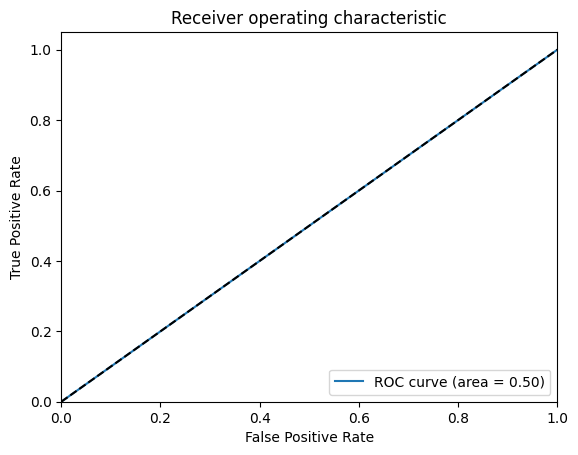

In [231]:
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_pred are 1D arrays
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [232]:
from tensorflow.keras.applications import Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [233]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(256, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [234]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [235]:
import numpy as np
from sklearn.utils import class_weight
# # Assuming you have a list of labels for your dataset, e.g., train_labels
train_labels = y_train  # Replace with the list of your training labels
# # Calculate class weights based on the frequency of each class
class_weights = class_weight.compute_class_weight(
class_weight='balanced',
classes=np.unique(train_labels),
y=train_labels
)
# # Convert class weights to a dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.7978723404255319, 1: 1.3392857142857142}


In [236]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.9051 - loss: 0.2807 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 4.3344e-04
Epoch 3/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 1.0000 - loss: 0.0040

KeyboardInterrupt: 